# Libraires

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import PassiveAggressiveClassifier #used to train the model
from sklearn.metrics import accuracy_score, confusion_matrix # this is used to analyze the results.
from sklearn.model_selection import train_test_split # to separate the dataset.
from sklearn.feature_extraction.text import TfidfVectorizer #used for the transformation of text data.
import pickle as pkl #file to save and load a model.

# Load Data

In [57]:
data=pd.read_csv('title_text.csv').drop(['Unnamed: 0'],axis=1)
data.head()

,title,text,isFake
0,Nancy Pelosi Backs BOMBSHELL Legislation That...,Donald Trump hasn t even been president for a ...,True
1,Ukraine prosecutor says puzzled by lack of U.S...,KIEV (Reuters) - Ukraine is puzzled by the lac...,False
2,Trump nominates businessman with Asia backgrou...,WASHINGTON (Reuters) - U.S. President Donald T...,False
3,Zimbabwe's Mnangagwa opens amnesty window for ...,"HARARE (Reuters) - Zimbabwe s new president, E...",False
4,OBAMA’S COMMUNIST ENVIRONMENTAL ARM Tells Kids...,Our children don t need the EPA to tell them h...,True


In [58]:
data=data.iloc[:500]

# Modification du text en données numériques.
Nous partons du principe que les données ont étés clean et que nous pouvons nous concerntrer à créer un model.

Comme les informations principales pour définir des Fake news et des vrai news, se base sur le texte et le titre, nous devons nous focaliser sur ces informations. Il faut ainsi que nous transformons le text et le titre en données afin que notre model puisse utiliser des données numériques pour trouver la bonne réponse. Nous allons utiliser la methode de TF-IDF vectorizing.

### TF-IDF vectorizer
Cette méthode offre la possibilité de déterminer les scores TF-IDF de nos données textuelles. Ce qui signifie : 

TF -> la Fréquence du Terme : le nombre de fois qu'un mot apparaît, en éliminant les mots qui ne sont pas importants.

IDF -> la fréquence inverse de détection : le même concept que TF, mais l'analyse va au-delà de la simple ligne, la fréquence dans l'ensemble du dataset est analysée.

Ces informations seront utilisées comme données pour notre modèle d'apprentissage automatique.

(il est important de faire cela uniquement sur nos données d'entraînement, sinon le modèle connaîtra les données de test)

In [59]:
X=data.drop(['isFake'],axis=1)
y=data['isFake']
#spearation en données d'entrainement et de test.
X_train, X_test, y_train, y_test = train_test_split(X['text'], y, test_size=0.2, random_state=42)

tfidf_vectorizer=TfidfVectorizer(use_idf=True)

# On fit et transforme les données d'entrainement.
tfidf_train=tfidf_vectorizer.fit_transform(X_train).toarray()

# on transfomer uniquement le test set, sinon il va connaitre les données test...
tfidf_test=tfidf_vectorizer.transform(X_test)

# Model Passive Agressive

Qu'est ce quil fait? 

TODO

In [60]:
filenm = 'PassiveAggressiveClassifier_model.pickle'

In [76]:
# we build our model: C is the regulation parameter, and denotes the penalization the model will make on an incorrect prediciton.
model = PassiveAggressiveClassifier(C = 0.2, 
                                    random_state = 5,
                                    early_stopping=True,# we enable the early stopping procedure.
                                    n_iter_no_change=3, #number of iterations before early stopping
                                    verbose=True,
                                    loss='hinge', #fonction de cout
                                   )


In [77]:
#on entraine le model sur les données d'entrainement.
model.fit(tfidf_train,y_train)
#Create or open a file with write-binary mode and save the model to it
pickle = pkl.dump(model, open(filenm, 'wb'))

-- Epoch 1
Norm: 5.49, NNZs: 12762, Bias: -0.484334, T: 354, Avg. loss: 0.756136
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 9.67, NNZs: 13293, Bias: -0.017074, T: 708, Avg. loss: 0.398460
Total training time: 0.10 seconds.
-- Epoch 3
Norm: 11.93, NNZs: 13323, Bias: -0.049279, T: 1062, Avg. loss: 0.190032
Total training time: 0.15 seconds.
-- Epoch 4
Norm: 13.31, NNZs: 13323, Bias: -0.175537, T: 1416, Avg. loss: 0.121816
Total training time: 0.20 seconds.
Convergence after 4 epochs took 0.22 seconds


In [78]:
#on sort les predictions
#Step 2: Open the saved file with read-binary mode
model = pkl.load(open(filenm, 'rb'))
y_pred=model.predict(tfidf_test)

# Optimisation

Le paramètre de régularisation es le moteur de l'évaluation des performances de notre modèle. L'objectif de ce paramètre est de dénoter la pénalisation de notre modèle.

In [82]:
# Définir les valeurs de C à tester
C_values = np.logspace(-4, 4, 20)
accuracy_scores = []

# Boucle sur les valeurs de C
for C in C_values:
    # Créer et entraîner le modèle Passive Aggressive
    model = PassiveAggressiveClassifier(C=C, random_state=42)
    model.fit(tfidf_train, y_train)
    
    # Évaluer le modèle sur l'ensemble de test
    y_pred = model.predict(tfidf_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

In [86]:
np.argmax(accuracy_scores)

8

In [87]:
C_values[8]

0.23357214690901212

# Model Evaluation

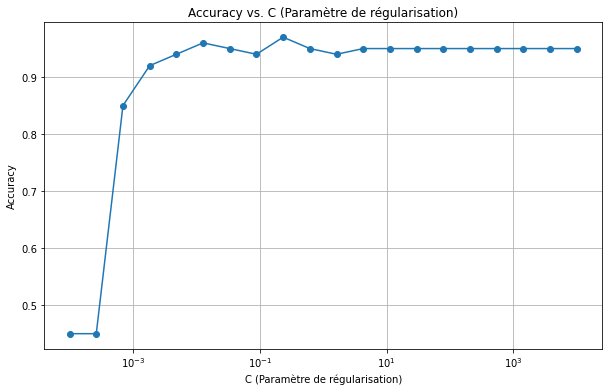

In [85]:
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, accuracy_scores, marker='o')
plt.title('Accuracy vs. C (Paramètre de régularisation)')
plt.xlabel('C (Paramètre de régularisation)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [79]:
#get the accuracy of our model.
acc= accuracy_score(y_test,y_pred)
print("The accuracy of our model: "+ str(round(acc*100,2))+"%")

The accuracy of our model: 90.0%


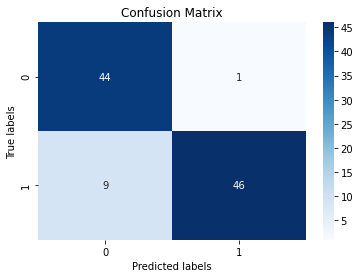

In [80]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()